In [1]:
!wget http://misc.0093.tv/misc/kadai.xlsx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import seaborn as sns
from sklearn.svm import SVR
dat = pd.read_excel("kadai.xlsx")
random_seed = 0
np.random.seed(random_seed)

--2024-08-05 15:01:19--  http://misc.0093.tv/misc/kadai.xlsx
Resolving misc.0093.tv (misc.0093.tv)... 219.94.129.235
Connecting to misc.0093.tv (misc.0093.tv)|219.94.129.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 906883 (886K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘kadai.xlsx’

kadai.xlsx          100%[===================>] 885.63K   388KB/s    in 2.3s    

2024-08-05 15:01:22 (388 KB/s) - ‘kadai.xlsx’ saved [906883/906883]



In [40]:
#データをdat1にコピーする
dat1 = dat
#"process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
dat1["process_end_time"] = pd.to_datetime(dat1["process_end_time"])
dat1["final_mes_time"] = pd.to_datetime(dat1["final_mes_time"])

#最後の500レコードをテストデータとする
learn = dat1[0:1776]
test = dat1[1776:2276]

#インデックスをリセットする
learn = learn.reset_index(drop=True)
test = test.reset_index(drop=True)

#テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

In [115]:
#説明変数と目的変数に分離
#学習データ
X_l = learn.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_l = learn.OV
#テストデータ
X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_t = test.OV
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
#ランダムフォレストによる木の深さ3の回帰木を構築
model = RandomForestRegressor(random_state=0)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [1, 3, 5, 7, 9, 11]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=rmse_scorer, cv=5)
grid_search.fit(X_l, Y_l)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best RMSE: {np.abs(grid_search.best_score_)}")

#予測値と観測値の比較
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_t)
test_rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))

print(f"Test RMSE: {test_rmse}")

KeyboardInterrupt: 

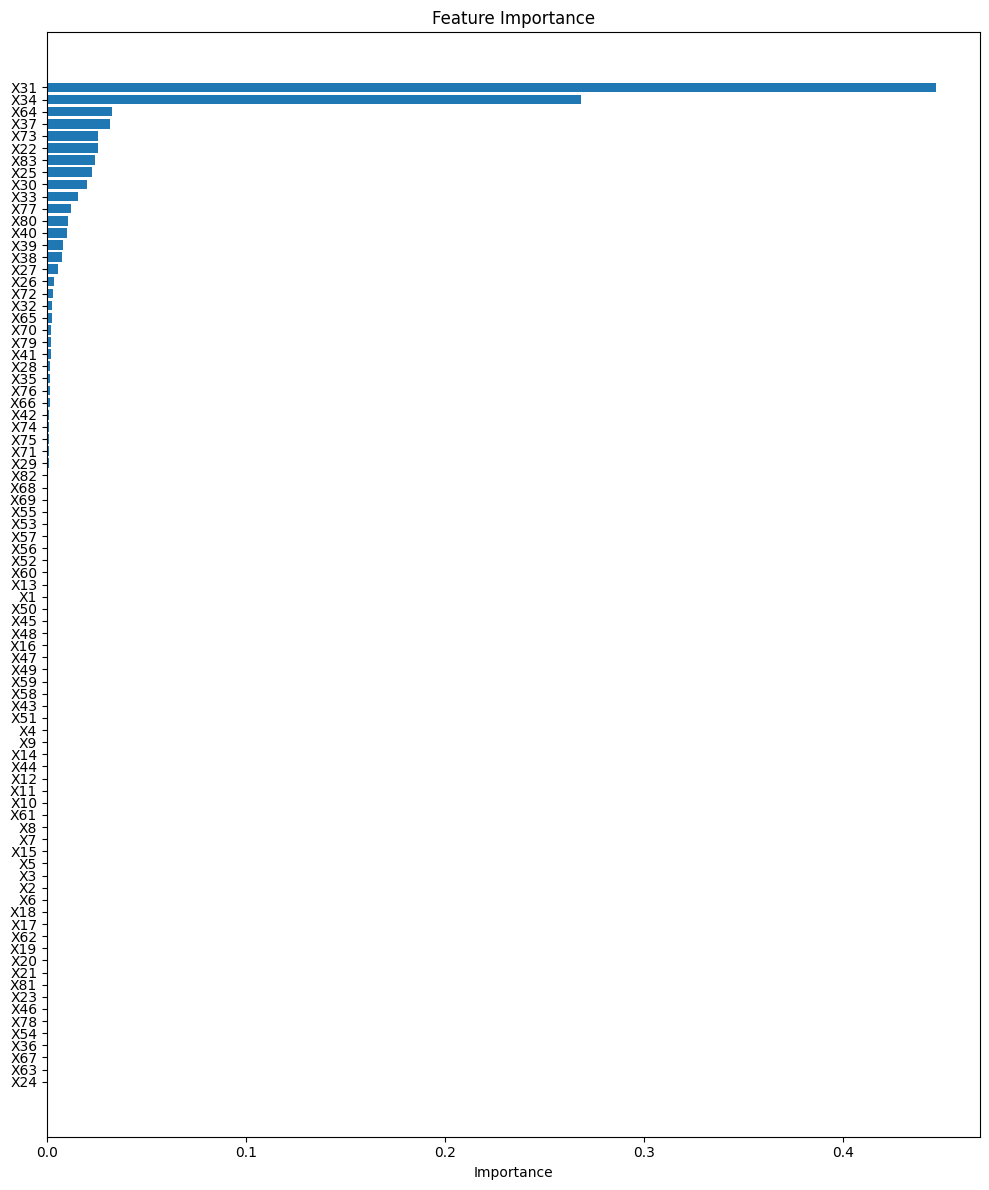

In [4]:
feature_names = X_l.columns

# 変数重要度を取得
importances = best_model.feature_importances_

# 変数重要度を降順にソートする
indices = np.argsort(importances)

# グラフを描画
plt.figure(figsize=(10,12))
plt.title("Feature Importance")
plt.barh(range(X_l.shape[1]), importances[indices], align='center')
plt.yticks(range(X_l.shape[1]), feature_names[indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

サポートベクターマシン

Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Selected features: Index(['X1', 'X2', 'X3', 'X9', 'X10', 'X11', 'X13', 'X14', 'X15', 'X16', 'X18',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X27', 'X28', 'X30', 'X31',
       'X34', 'X35', 'X37', 'X38', 'X40', 'X41', 'X42', 'X46', 'X47', 'X48',
       'X49', 'X51', 'X54', 'X55', 'X57', 'X60', 'X61', 'X62', 'X70', 'X72'],
      dtype='object')


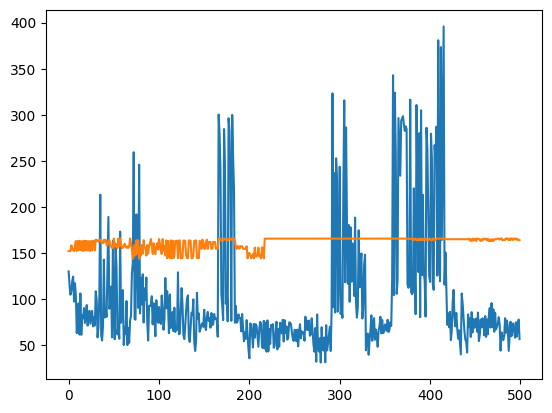

Train RMSE: 26.4483
Test RMSE: 80.1868


In [45]:
dat1 = dat
#"process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
dat1["process_end_time"] = pd.to_datetime(dat1["process_end_time"])
dat1["final_mes_time"] = pd.to_datetime(dat1["final_mes_time"])

#最後の500レコードをテストデータとする
learn = dat1[0:1776]
test = dat1[1776:2276]

#インデックスをリセットする
learn = learn.reset_index(drop=True)
test = test.reset_index(drop=True)

#テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
X_l = learn.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_l = learn.OV
#テストデータ
X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)

# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Selected features: Index(['X2', 'X9', 'X10', 'X13', 'X14', 'X20', 'X22', 'X24', 'X25', 'X27',
       'X28', 'X30', 'X31', 'X34', 'X37', 'X40', 'X42', 'X51', 'X57', 'X70',
       'X72'],
      dtype='object')


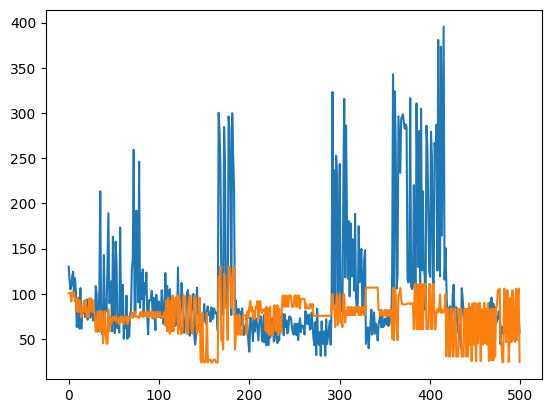

Train RMSE: 25.1362
Test RMSE: 64.7709


In [123]:
dat1 = dat
#"process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
dat1["process_end_time"] = pd.to_datetime(dat1["process_end_time"])
dat1["final_mes_time"] = pd.to_datetime(dat1["final_mes_time"])

#最後の500レコードをテストデータとする
learn = dat1[0:1776]
test = dat1[1776:2276]

#インデックスをリセットする
learn = learn.reset_index(drop=True)
test = test.reset_index(drop=True)
X_l = learn[['X1', 'X2', 'X3', 'X9', 'X10', 'X11', 'X13', 'X14', 'X15', 'X16', 'X18',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X27', 'X28', 'X30', 'X31',
       'X34', 'X35', 'X37', 'X38', 'X40', 'X41', 'X42', 'X46', 'X47', 'X48',
       'X49', 'X51', 'X54', 'X55', 'X57', 'X60', 'X61', 'X62', 'X70', 'X72']]
Y_l = learn.OV
#テストデータ
X_t = test[['X1', 'X2', 'X3', 'X9', 'X10', 'X11', 'X13', 'X14', 'X15', 'X16', 'X18',
       'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X27', 'X28', 'X30', 'X31',
       'X34', 'X35', 'X37', 'X38', 'X40', 'X41', 'X42', 'X46', 'X47', 'X48',
       'X49', 'X51', 'X54', 'X55', 'X57', 'X60', 'X61', 'X62', 'X70', 'X72']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction="backward", scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)

# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Selected features: Index(['X9', 'X10', 'X13', 'X20', 'X25', 'X30', 'X31', 'X51', 'X57', 'X72'], dtype='object')


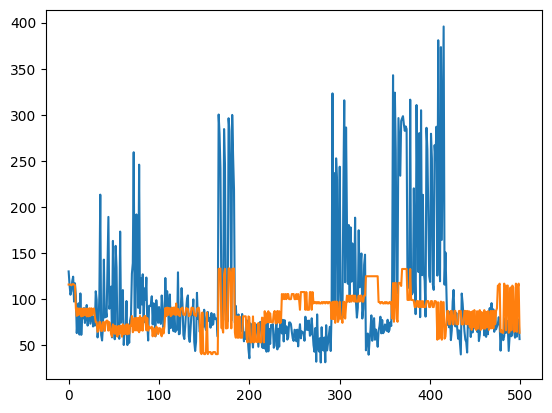

Train RMSE: 27.8617
Test RMSE: 66.2331


In [124]:
dat1 = dat
#"process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
dat1["process_end_time"] = pd.to_datetime(dat1["process_end_time"])
dat1["final_mes_time"] = pd.to_datetime(dat1["final_mes_time"])

#最後の500レコードをテストデータとする
learn = dat1[0:1776]
test = dat1[1776:2276]

#インデックスをリセットする
learn = learn.reset_index(drop=True)
test = test.reset_index(drop=True)
X_l = learn[['X2', 'X9', 'X10', 'X13', 'X14', 'X20', 'X22', 'X24', 'X25', 'X27',
       'X28', 'X30', 'X31', 'X34', 'X37', 'X40', 'X42', 'X51', 'X57', 'X70',
       'X72']]
Y_l = learn.OV
#テストデータ
X_t = test[['X2', 'X9', 'X10', 'X13', 'X14', 'X20', 'X22', 'X24', 'X25', 'X27',
       'X28', 'X30', 'X31', 'X34', 'X37', 'X40', 'X42', 'X51', 'X57', 'X70',
       'X72']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)

# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Selected features: Index(['X34', 'X37', 'X22', 'X83', 'X30'], dtype='object')


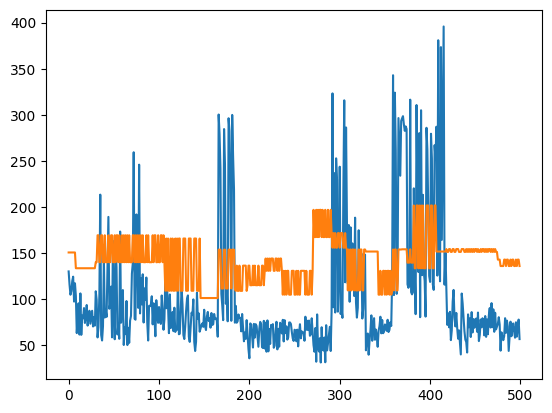

Train RMSE: 32.7401
Test RMSE: 75.8647


In [43]:
X_l = learn[['X31','X34','X64','X37','X73','X22','X83','X25','X30','X33']]
Y_l = learn.OV
#テストデータ
X_t = test[['X31','X34','X64','X37','X73','X22','X83','X25','X30','X33']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)

# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Selected features: Index(['X25', 'X30', 'X33'], dtype='object')


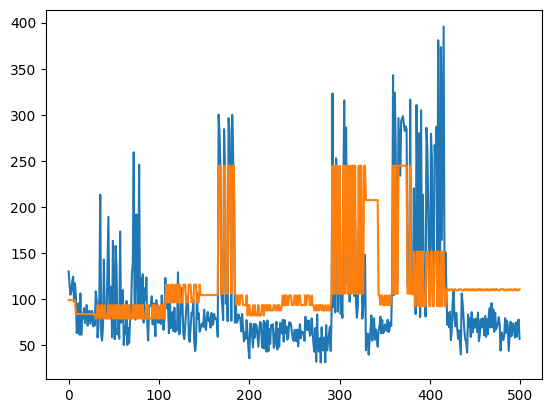

Train RMSE: 42.6661
Test RMSE: 52.9612


In [128]:
X_l = learn[['X34', 'X37', 'X25', 'X30', 'X33']]
Y_l = learn.OV
#テストデータ
X_t = test[['X34', 'X37', 'X25', 'X30', 'X33']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)

# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

回帰分析

In [12]:
X_l = learn.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_l = learn.OV

# テストデータ
X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
31.69306155395227
テストデータに対するRMSE:
272.39710243223305
回帰係数: [-9.41086872e+01 -2.41352889e+03  8.84107787e+00 -3.16135214e+01
  4.27928569e+00 -1.08688432e+01 -6.55468756e+01  3.12665094e-09
 -2.85439976e+01 -3.01201270e+02 -3.25418318e+00  5.16671353e+00
  2.43018675e+01 -3.37067058e+00  1.86916398e+01  5.11106900e+00
  1.21126211e+01  1.84656573e+02 -8.02084113e-01  3.39797137e+01
  4.75962437e+01 -5.60295113e+01 -2.12969203e-01  1.79125165e-02
  7.80352448e+02  8.48026547e+01  5.67071422e+00  1.29822415e-01
 -4.98005046e+02 -1.68476922e+02  7.10733788e+00 -7.54192380e+01
  4.02245638e+00  1.98701808e+01  4.41492231e+01 -4.19015955e+02
  5.12998508e+01  5.79083470e+00  1.96299289e+02  2.20983182e+03
  7.02557105e+02]
切片: 499.5756006793161
選択された特徴量: Index(['X4', 'X6', 'X8', 'X15', 'X18', 'X20', 'X21', 'X23', 'X25', 'X26',
       'X27', 'X28', 'X30', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38',
       'X39', 'X40', 'X44', 'X45', 'X47', 'X48', 'X50', 'X51', 'X52', 'X55'

In [13]:
X_l = learn[['X4', 'X6', 'X8', 'X15', 'X18', 'X20', 'X21', 'X23', 'X25', 'X26',
       'X27', 'X28', 'X30', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38',
       'X39', 'X40', 'X44', 'X45', 'X47', 'X48', 'X50', 'X51', 'X52', 'X55',
       'X56', 'X58', 'X60', 'X62', 'X63', 'X65', 'X70', 'X72', 'X78', 'X80',
       'X83']]
Y_l = learn.OV

# テストデータ
X_t = test[['X4', 'X6', 'X8', 'X15', 'X18', 'X20', 'X21', 'X23', 'X25', 'X26',
       'X27', 'X28', 'X30', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38',
       'X39', 'X40', 'X44', 'X45', 'X47', 'X48', 'X50', 'X51', 'X52', 'X55',
       'X56', 'X58', 'X60', 'X62', 'X63', 'X65', 'X70', 'X72', 'X78', 'X80',
       'X83']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
32.91250226786107
テストデータに対するRMSE:
147.79145508968793
回帰係数: [ 1.64917357e+00 -3.31540416e+01 -2.08785971e+01 -2.56611814e+02
  2.31998389e+01 -6.65787404e+00  1.45112304e+01  1.57510450e+01
 -6.45260345e-01  8.30770849e+01 -2.58648922e+01  6.69473497e+01
  2.13657333e+00 -1.63192619e+02  2.51452877e+00 -4.78937091e+01
  2.86050507e+00 -6.89564156e+02  4.81805162e+01  1.30311503e+03
  8.48778547e+02]
切片: 211.95137634741724
選択された特徴量: Index(['X8', 'X21', 'X25', 'X26', 'X30', 'X32', 'X33', 'X35', 'X37', 'X39',
       'X40', 'X48', 'X50', 'X52', 'X56', 'X58', 'X60', 'X65', 'X70', 'X80',
       'X83'],
      dtype='object')


In [14]:
X_l = learn[['X8', 'X21', 'X25', 'X26', 'X30', 'X32', 'X33', 'X35', 'X37', 'X39',
       'X40', 'X48', 'X50', 'X52', 'X56', 'X58', 'X60', 'X65', 'X70', 'X80',
       'X83']]
Y_l = learn.OV

# テストデータ
X_t = test[['X8', 'X21', 'X25', 'X26', 'X30', 'X32', 'X33', 'X35', 'X37', 'X39',
       'X40', 'X48', 'X50', 'X52', 'X56', 'X58', 'X60', 'X65', 'X70', 'X80',
       'X83']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
34.799792359813225
テストデータに対するRMSE:
106.30831282204932
回帰係数: [-2.01363434e+01 -2.10528099e+02  2.43026961e+01 -8.74172083e+00
  1.29659529e+01 -5.59420714e-01  7.81255769e+01  1.12451702e-01
  5.00701107e+01  6.67913825e+02]
切片: 125.88439922527903
選択された特徴量: Index(['X25', 'X26', 'X30', 'X32', 'X33', 'X37', 'X39', 'X50', 'X70', 'X83'], dtype='object')


In [15]:
X_l = learn[['X25', 'X26', 'X30', 'X32', 'X33', 'X37', 'X39', 'X50', 'X70', 'X83']]
Y_l = learn.OV

# テストデータ
X_t = test[['X25', 'X26', 'X30', 'X32', 'X33', 'X37', 'X39', 'X50', 'X70', 'X83']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
37.75970040705127
テストデータに対するRMSE:
84.73863142488257
回帰係数: [-202.30239087   17.62531064   -9.09773423   10.54300578  841.87545922]
切片: 126.54973711835984
選択された特徴量: Index(['X26', 'X30', 'X32', 'X33', 'X83'], dtype='object')


In [16]:
X_l = learn[['X26', 'X30', 'X32', 'X33', 'X83']]
Y_l = learn.OV

# テストデータ
X_t = test[['X26', 'X30', 'X32', 'X33', 'X83']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
43.84615079703811
テストデータに対するRMSE:
75.43194177390822
回帰係数: [ 11.65723359 731.68692415]
切片: 108.0615836961735
選択された特徴量: Index(['X33', 'X83'], dtype='object')


In [17]:
X_l = learn[['X33', 'X83']]
Y_l = learn.OV

# テストデータ
X_t = test[['X33', 'X83']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
46.636939493850974
テストデータに対するRMSE:
73.76882634651098
回帰係数: [13.368986]
切片: 125.34115939349772
選択された特徴量: Index(['X33'], dtype='object')


In [131]:
X_l = learn[['X31','X34','X64','X37','X73','X22','X83','X25','X30','X33']]
Y_l = learn.OV

# テストデータ
X_t = test[['X31','X34','X64','X37','X73','X22','X83','X25','X30','X33']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
40.11760278871213
テストデータに対するRMSE:
54.14717805347795
回帰係数: [ -3.73016468  -0.4017735  -25.16076172  20.25191334  13.38910882]
切片: 118.68005386835421
選択された特徴量: Index(['X34', 'X37', 'X25', 'X30', 'X33'], dtype='object')


In [132]:
X_l = learn[['X34', 'X37', 'X25', 'X30', 'X33']]
Y_l = learn.OV

# テストデータ
X_t = test[['X34', 'X37', 'X25', 'X30', 'X33']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
42.10941760701632
テストデータに対するRMSE:
52.40883614017718
回帰係数: [-35.16327489  13.37572804  14.29454408]
切片: 107.78773224307638
選択された特徴量: Index(['X25', 'X30', 'X33'], dtype='object')


In [133]:
X_l = learn[['X25', 'X30', 'X33']]
Y_l = learn.OV

# テストデータ
X_t = test[['X25', 'X30', 'X33']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')

学習データに対するRMSE:
47.13857783908569
テストデータに対するRMSE:
68.00023528522676
回帰係数: [18.13881065]
切片: 101.82981554511778
選択された特徴量: Index(['X33'], dtype='object')


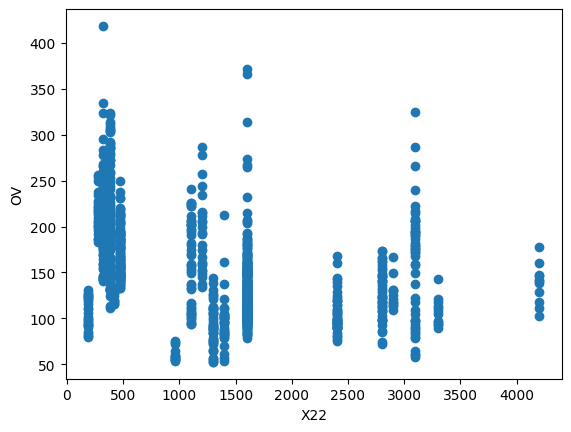

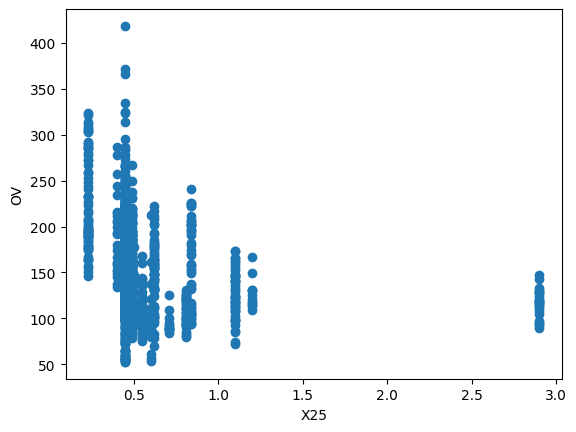

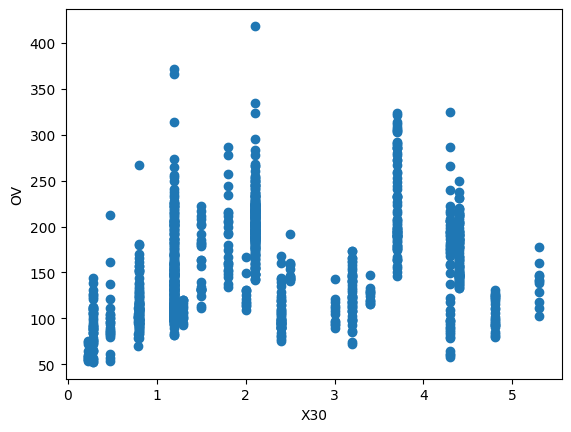

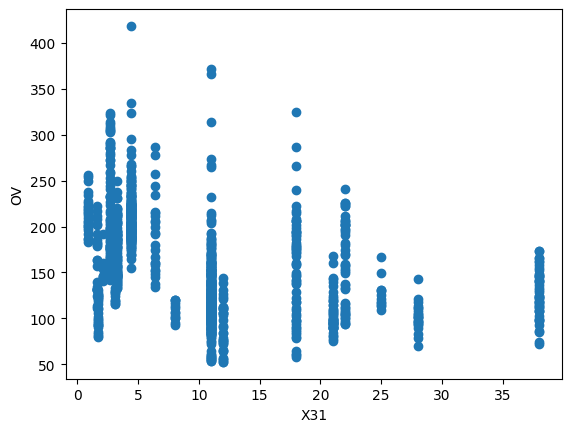

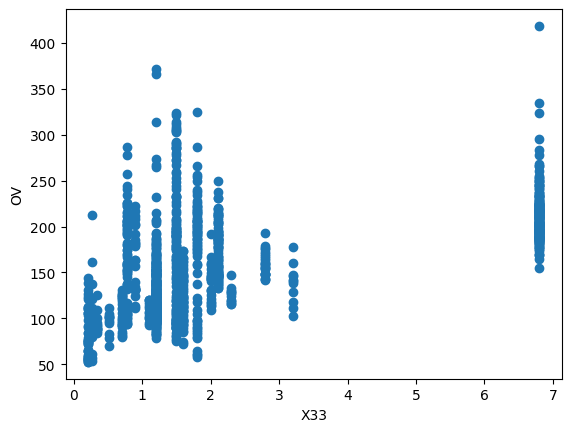

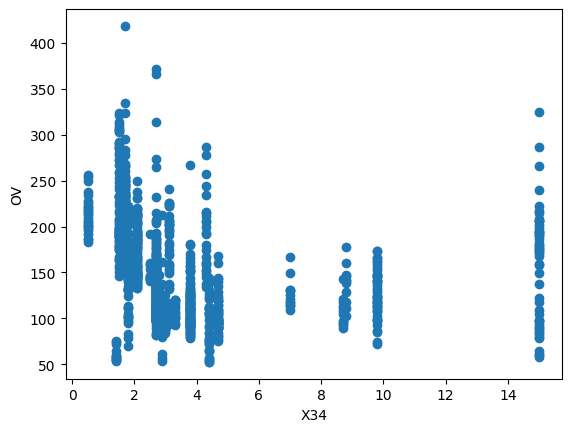

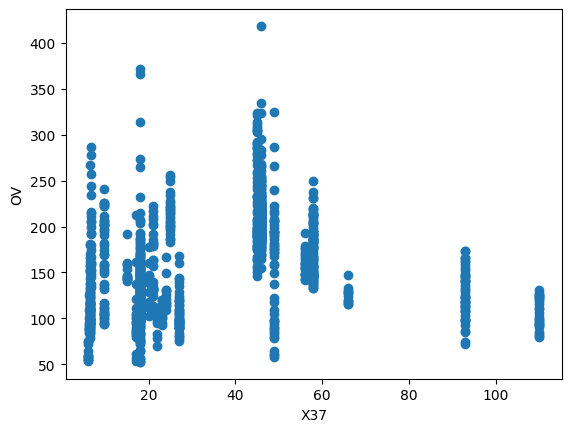

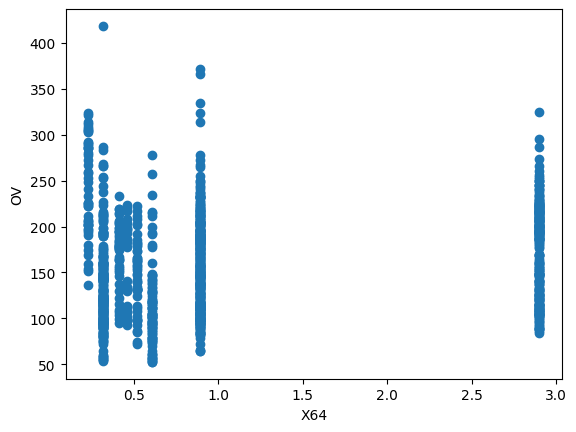

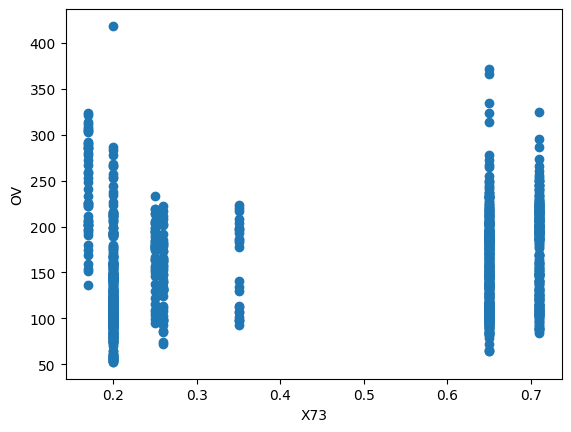

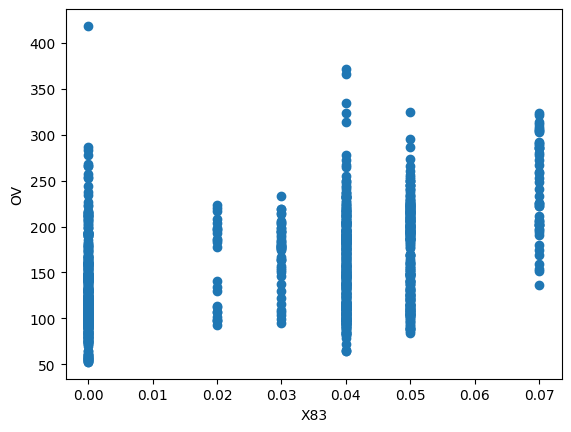

In [7]:
X_l = learn[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83']]
Y_l = learn.OV
# テストデータ
X_t = test[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83']]
Y_t = test.OV
plt.scatter(X_l['X22'], Y_l)
plt.xlabel('X22')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X25'], Y_l)
plt.xlabel('X25')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X30'], Y_l)
plt.xlabel('X30')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X31'], Y_l)
plt.xlabel('X31')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X33'], Y_l)
plt.xlabel('X33')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X34'], Y_l)
plt.xlabel('X34')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X37'], Y_l)
plt.xlabel('X37')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X64'], Y_l)
plt.xlabel('X64')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X73'], Y_l)
plt.xlabel('X73')
plt.ylabel('OV')
plt.show()

plt.scatter(X_l['X83'], Y_l)
plt.xlabel('X83')
plt.ylabel('OV')
plt.show()

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


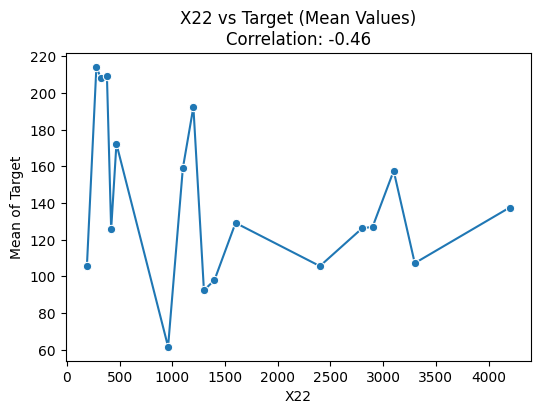

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


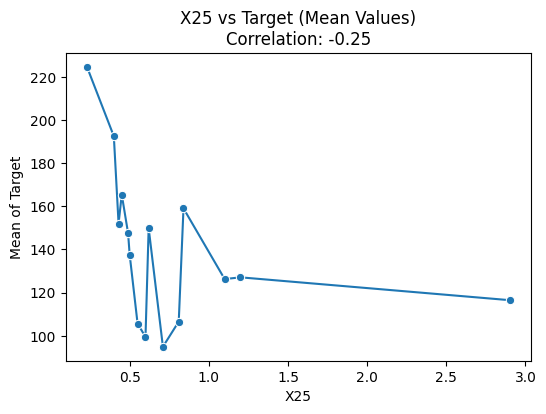

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


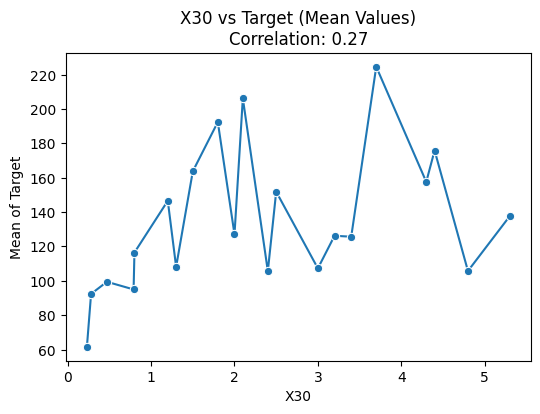

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


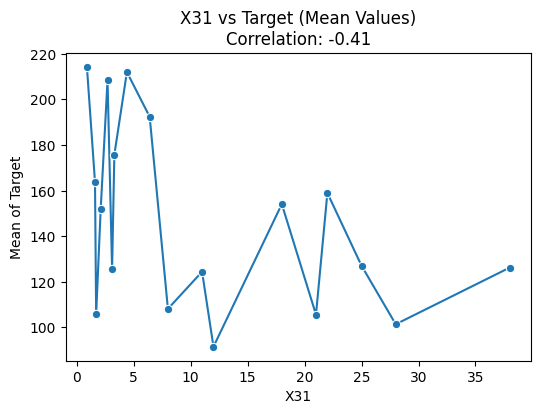

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


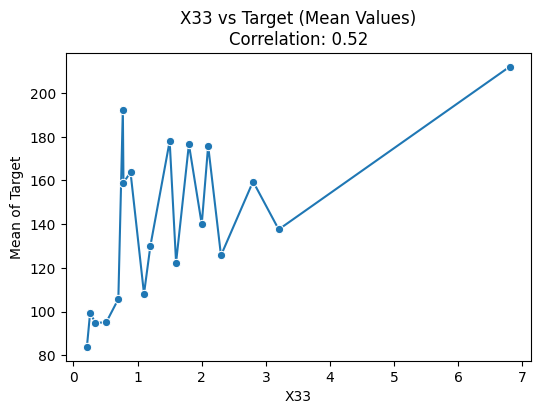

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


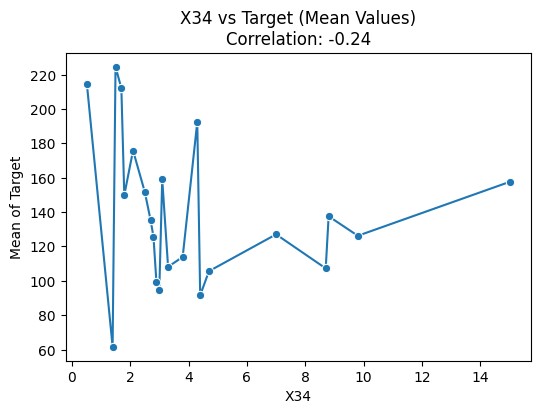

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


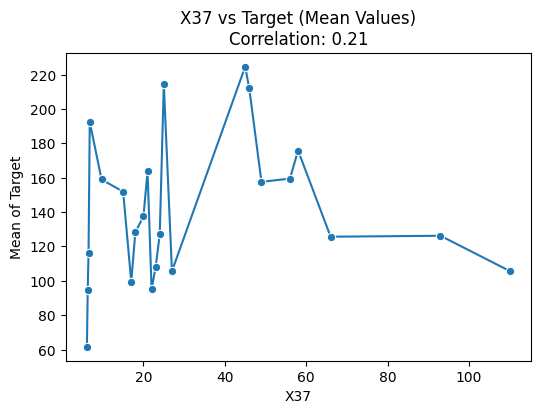

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


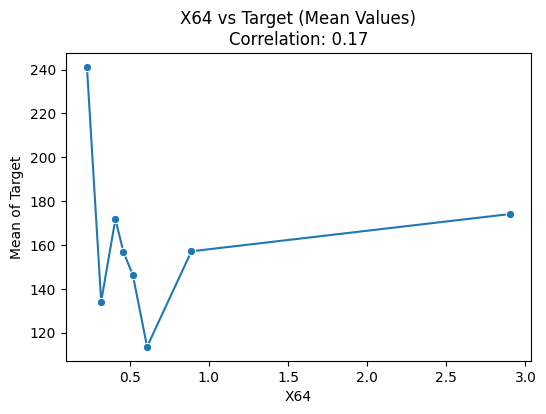

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


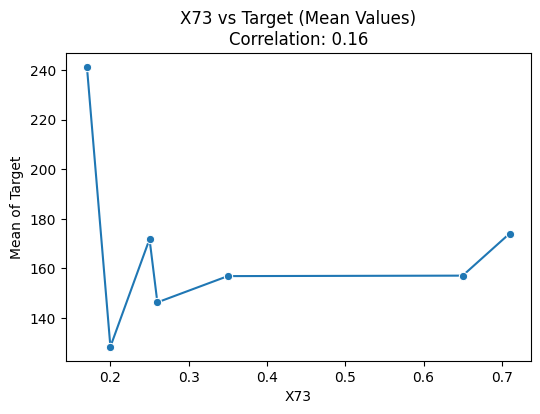

<ipython-input-9-5db11b4ff3d7>:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)


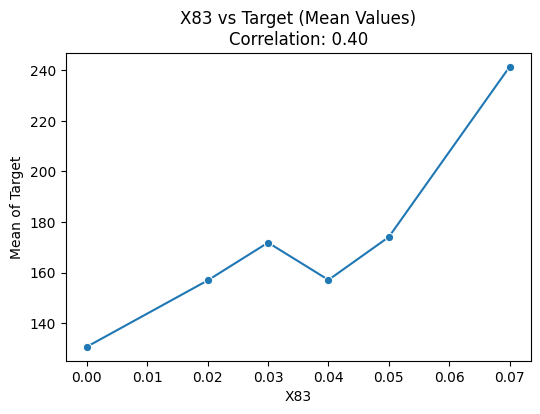

In [9]:
X_l = learn[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83']]
Y_l = learn.OV

# テストデータ
X_t = test[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83']]
Y_t = test.OV
for column in X_l.columns:
    plt.figure(figsize=(6, 4))
    data = pd.DataFrame({column: X_l[column], 'Target': Y_l})
    correlation = np.corrcoef(X_l[column], Y_l)[0, 1]
    sns.lineplot(x=column, y='Target', data=data, marker='o', ci=None)

    plt.title(f'{column} vs Target (Mean Values)\nCorrelation: {correlation:.2f}')
    plt.ylabel('Mean of Target')
    plt.show()

In [18]:
X_l2 = learn[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83']]
Y_l2 = learn.OV

# テストデータ
X_t2 = test[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83']]
Y_t2 = test.OV
X_l2['logX25']=np.log(X_l2['X25'])
X_t2['logX25']=np.log(X_t2['X25'])
X_l2['X30^4']=X_l2['X30']**4
X_t2['X30^4']=X_t2['X30']**4
X_l2['X30^3']=X_l2['X30']**3
X_t2['X30^3']=X_t2['X30']**3
X_l2['X30^2']=X_l2['X30']**2
X_t2['X30^2']=X_t2['X30']**2
X_l2['logX34']=np.log(X_l2['X34'])
X_t2['logX34']=np.log(X_t2['X34'])
X_l2['logX37']=np.log(X_l2['X37'])
X_t2['logX37']=np.log(X_t2['X37'])
X_l2['logX64']=np.log(X_l2['X64'])
X_t2['logX64']=np.log(X_t2['X64'])
X_l2['logX73']=np.log(X_l2['X73'])
X_t2['logX73']=np.log(X_t2['X73'])
X_l2['logX30']=np.log(X_l2['X30'])
X_t2['logX30']=np.log(X_t2['X30'])

<ipython-input-18-d51c9c4e2fc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_l2['logX25']=np.log(X_l2['X25'])
<ipython-input-18-d51c9c4e2fc6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_t2['logX25']=np.log(X_t2['X25'])
<ipython-input-18-d51c9c4e2fc6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

非線形サポートベクター

Best hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Selected features: Index(['X30', 'X33', 'X34', 'X83', 'logX25', 'X30^4', 'X30^3', 'X30^2',
       'logX34'],
      dtype='object')


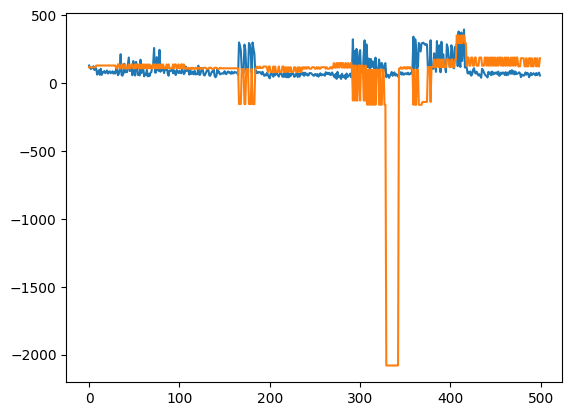

Train RMSE: 37.5746
Test RMSE: 381.6719


In [15]:
X_l = X_l2[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83','logX25','X30^4','X30^3','X30^2','logX34','logX37','logX64','logX73']]
Y_l = learn.OV

# テストデータ
X_t = X_t2[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83','logX25','X30^4','X30^3','X30^2','logX34','logX37','logX64','logX73']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

Best hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Selected features: Index(['X22', 'X25', 'X31', 'X33', 'X83', 'logX25', 'logX30', 'logX34'], dtype='object')


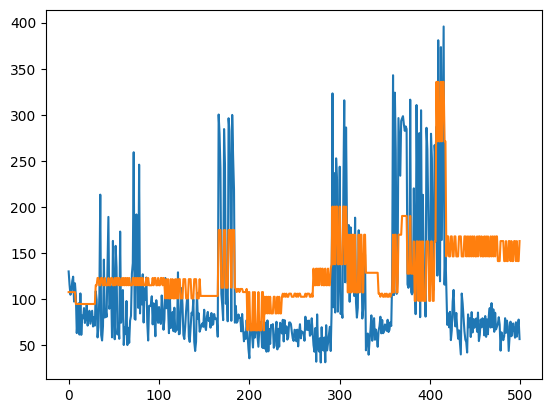

Train RMSE: 37.8284
Test RMSE: 60.3270


In [19]:
X_l = X_l2[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83','logX25','logX30','logX34','logX37','logX64','logX73']]
Y_l = learn.OV

# テストデータ
X_t = X_t2[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83','logX25','logX30','logX34','logX37','logX64','logX73']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

Best hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Selected features: Index(['X33', 'X83', 'logX30', 'logX34'], dtype='object')


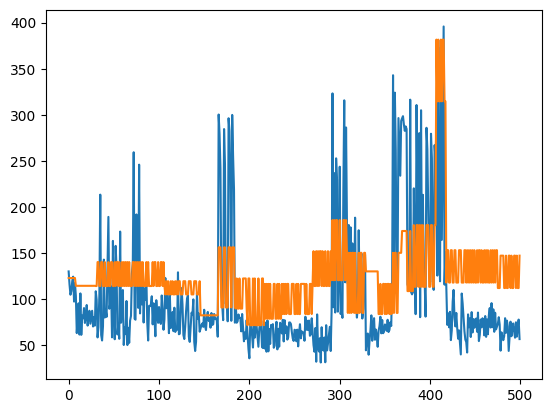

Train RMSE: 38.8021
Test RMSE: 60.8350


In [21]:
X_l = X_l2[['X22', 'X25', 'X31', 'X33', 'X83', 'logX25', 'logX30', 'logX34']]
Y_l = learn.OV

# テストデータ
X_t = X_t2[['X22', 'X25', 'X31', 'X33', 'X83', 'logX25', 'logX30', 'logX34']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

非線形回帰

学習データに対するRMSE:
36.08585816424792
テストデータに対するRMSE:
172.0583293538561
回帰係数: [ 5.24527264e-01  6.53141225e+01  5.17744423e+00  6.04538574e+00
  5.98340354e+02 -1.52594827e+01 -9.50004161e+00 -4.89813015e+01
 -1.16171078e+01]
切片: 103.10985169448696
選択された特徴量: Index(['X25', 'X30', 'X33', 'X34', 'X83', 'logX25', 'X30^2', 'logX34',
       'logX37'],
      dtype='object')


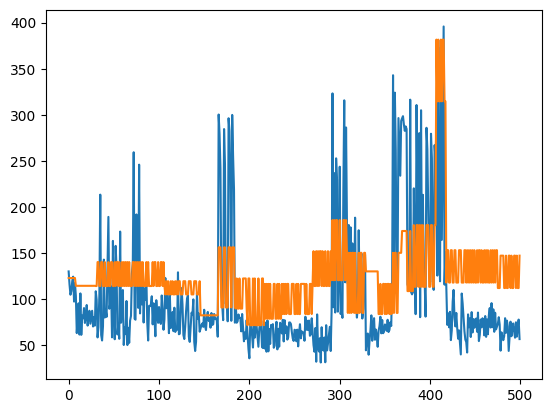

RMSE:
172.0583293538561
回帰係数: [ 5.24527264e-01  6.53141225e+01  5.17744423e+00  6.04538574e+00
  5.98340354e+02 -1.52594827e+01 -9.50004161e+00 -4.89813015e+01
 -1.16171078e+01]
切片: 103.10985169448696


In [22]:
X_l = X_l2[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83','logX25','X30^4','X30^3','X30^2','logX34','logX37','logX64','logX73']]
Y_l = learn.OV

# テストデータ
X_t = X_t2[['X22','X25','X30','X31','X33','X34','X37','X64','X73','X83','logX25','X30^4','X30^3','X30^2','logX34','logX37','logX64','logX73']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_test_pred))
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
print("RMSE:")
print(rmse)
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')

学習データに対するRMSE:
37.63214089768091
テストデータに対するRMSE:
229.1781709399905
回帰係数: [ 77.5102502  745.91638349 -19.66788804 -12.10132804 -22.70194455]
切片: 54.53136443275905
選択された特徴量: Index(['X30', 'X83', 'logX25', 'X30^2', 'logX34'], dtype='object')


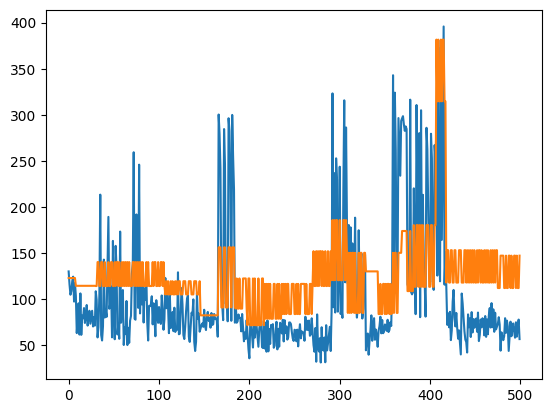

RMSE:
229.1781709399905
回帰係数: [ 77.5102502  745.91638349 -19.66788804 -12.10132804 -22.70194455]
切片: 54.53136443275905


In [23]:
X_l = X_l2[['X25', 'X30', 'X33', 'X34', 'X83', 'logX25', 'X30^2', 'logX34',
       'logX37']]
Y_l = learn.OV

# テストデータ
X_t = X_t2[['X25', 'X30', 'X33', 'X34', 'X83', 'logX25', 'X30^2', 'logX34',
       'logX37']]
Y_t = test.OV

model = LinearRegression()

# 前向きステップワイズ回帰による特徴量選択
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l, Y_l)

# 選択された特徴量を取得
selected_features = X_l.columns[sfs.get_support()]

# 選択された特徴量で再度学習と評価
model.fit(X_l[selected_features], Y_l)

# 学習データに対する予測
Y_train_pred = model.predict(X_l[selected_features])

# テストデータに対する予測
Y_test_pred = model.predict(X_t[selected_features])

# 学習データに対するRMSEの計算
rmse_train = np.sqrt(mean_squared_error(Y_l, Y_train_pred))

# テストデータに対するRMSEの計算
rmse_test = np.sqrt(mean_squared_error(Y_t, Y_test_pred))

# RMSEの表示
print("学習データに対するRMSE:")
print(rmse_train)
print("テストデータに対するRMSE:")
print(rmse_test)

# 回帰係数と切片、選択された特徴量の表示
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')
print(f'選択された特徴量: {selected_features}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_test_pred))
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
print("RMSE:")
print(rmse)
print(f'回帰係数: {model.coef_}')
print(f'切片: {model.intercept_}')

In [62]:
dat2=dat1[['X30','X33','X34','X83']]
dat2['logX30']=np.log(dat1['X30'])
dat2['logX34']=np.log(dat1['X34'])
dat2['X33*X83']=dat1['X33']*dat1['X83']
dat2['X33*logX30']=dat1['X33']*np.log(dat1['X30'])
dat2['X33*logX34']=dat1['X33']*np.log(dat1['X34'])
dat2['X83*logX30']=dat1['X83']*np.log(dat1['X30'])
dat2['X83*logX34']=dat1['X83']*np.log(dat1['X34'])
dat2['logX30*logX34']=np.log(dat1['X34'])*np.log(dat1['X34'])
dat2["final_mes_time"]=dat1["final_mes_time"]
dat2['process_end_time']=dat1['process_end_time']
dat2['OV']=dat1['OV']
#"process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
dat2["process_end_time"] = pd.to_datetime(dat2["process_end_time"])
dat2["final_mes_time"] = pd.to_datetime(dat2["final_mes_time"])

#最後の500レコードをテストデータとする
learn = dat2[0:1776]
test = dat2[1776:2276]

#インデックスをリセットする
learn = learn.reset_index(drop=True)
test = test.reset_index(drop=True)

#テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

<ipython-input-62-cd4426dbf9c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2['logX30']=np.log(dat1['X30'])
<ipython-input-62-cd4426dbf9c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2['logX34']=np.log(dat1['X34'])
<ipython-input-62-cd4426dbf9c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

SVM②の交互作用

Best hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Selected features: Index(['X33', 'logX30', 'logX34', 'X33*X83', 'X83*logX30', 'logX30*logX34'], dtype='object')


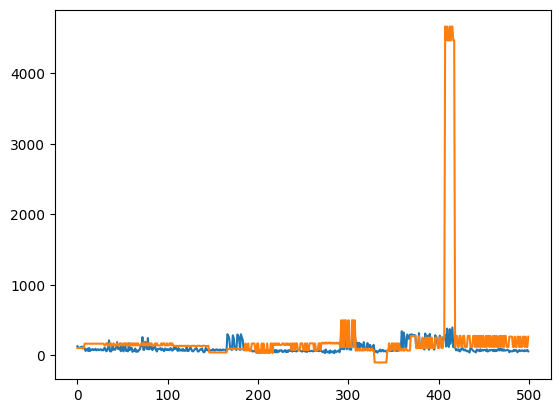

Train RMSE: 33.6049
Test RMSE: 649.6659


In [47]:
X_l = learn.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_l = learn.OV
#テストデータ
X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

In [48]:
dat2=dat1[['X30','X33','X34','X83']]
dat2['logX30']=np.log(dat1['X30'])
dat2['logX34']=np.log(dat1['X34'])
dat2['X33*logX30']=dat1['X33']*np.log(dat1['X30'])
dat2['X33*logX34']=dat1['X33']*np.log(dat1['X34'])
dat2['X83*logX30']=dat1['X83']*np.log(dat1['X30'])
dat2['X83*logX34']=dat1['X83']*np.log(dat1['X34'])
dat2['logX30*logX34']=np.log(dat1['X34'])*np.log(dat1['X34'])
dat2["final_mes_time"]=dat1["final_mes_time"]
dat2['process_end_time']=dat1['process_end_time']
dat2['OV']=dat1['OV']
#"process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
dat2["process_end_time"] = pd.to_datetime(dat2["process_end_time"])
dat2["final_mes_time"] = pd.to_datetime(dat2["final_mes_time"])

#最後の500レコードをテストデータとする
learn = dat2[0:1776]
test = dat2[1776:2276]

#インデックスをリセットする
learn = learn.reset_index(drop=True)
test = test.reset_index(drop=True)

#テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

<ipython-input-48-2976b34c24b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2['logX30']=np.log(dat1['X30'])
<ipython-input-48-2976b34c24b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2['logX34']=np.log(dat1['X34'])
<ipython-input-48-2976b34c24b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Selected features: Index(['X33', 'logX30', 'logX34', 'X33*logX34', 'X83*logX30'], dtype='object')


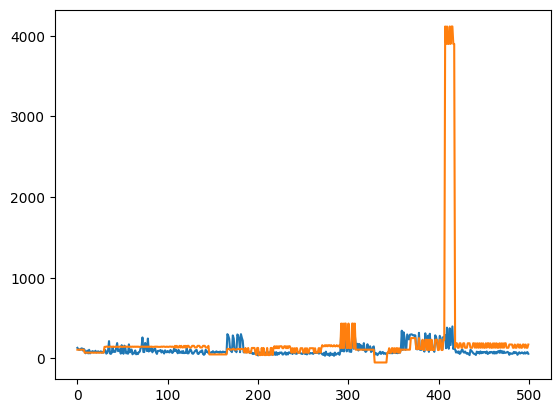

Train RMSE: 34.0655
Test RMSE: 563.3958


In [50]:
X_l = learn.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_l = learn.OV
#テストデータ
X_t = test.drop(['process_end_time', 'final_mes_time', 'OV'], axis=1)
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='forward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

Best hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Selected features: Index(['X33', 'logX30', 'X83*logX30'], dtype='object')


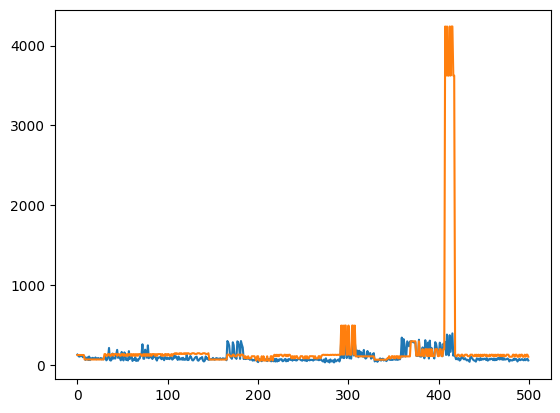

Train RMSE: 37.9884
Test RMSE: 548.7563


In [52]:
X_l = learn[['X33', 'logX30', 'logX34', 'X33*logX34', 'X83*logX30']]
Y_l = learn.OV
#テストデータ
X_t = test[['X33', 'logX30', 'logX34', 'X33*logX34', 'X83*logX30']]
Y_t = test.OV
scaler = StandardScaler()
X_l_scaled = scaler.fit_transform(X_l)
X_t_scaled = scaler.transform(X_t)

# SVMモデルの定義
svr = SVR()

# グリッドサーチのハイパーパラメータ設定
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

# グリッドサーチによるモデルの最適化
grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_l_scaled, Y_l)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータを表示
print(f'Best hyperparameters: {grid_search.best_params_}')

# 逐次特徴選択の設定
sfs = SequentialFeatureSelector(best_model, n_features_to_select='auto',direction='backward', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X_l_scaled, Y_l)

# 選択された特徴量のインデックスを取得
selected_features = sfs.get_support(indices=True)

# 採用された変数を表示
selected_feature_names = X_l.columns[selected_features]
print(f'Selected features: {selected_feature_names}')

# 選択された特徴量のみを使用してモデルのトレーニング
X_l_selected = X_l_scaled[:, selected_features]
X_t_selected = X_t_scaled[:, selected_features]

best_model.fit(X_l_selected, Y_l)
# テストデータで予測
Y_l_pred = best_model.predict(X_l_selected)
Y_pred = best_model.predict(X_t_selected)
plt.plot(Y_t)
plt.plot(Y_pred, linestyle='-')
plt.show()
# RMSEの計算
train_rmse = np.sqrt(mean_squared_error(Y_l, Y_l_pred))
print(f'Train RMSE: {train_rmse:.4f}')
rmse = np.sqrt(mean_squared_error(Y_t, Y_pred))
print(f'Test RMSE: {rmse:.4f}')

パラメータ更新

SVM1

線形

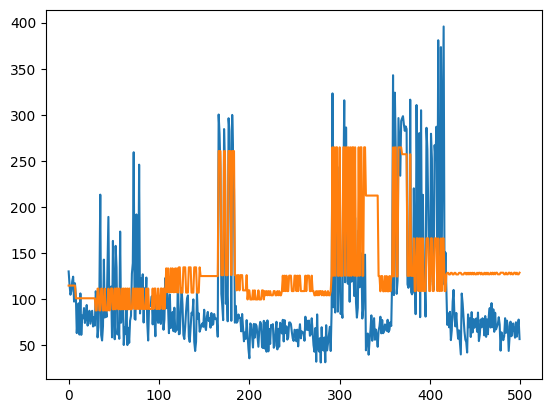

RMSE:


58.681198788193605

In [65]:
yHat = []

for i in np.arange(1776, 2276):
  #最後の500レコードをテストデータとする
  learn = dat1[0:i]
  test = dat1[i:i+1]
  #インデックスをリセットする
  learn = learn.reset_index(drop=True)
  test = test.reset_index(drop=True)
  #テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
  learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
  #説明変数と目的変数に分離
  #学習データ
  X_l = learn[['X25','X30', 'X33', 'X34', 'X37']]
  Y_l = learn.OV
  #テストデータ
  X_t = test[['X25','X30', 'X33', 'X34', 'X37']]
  Y_t = test.OV
  model = LinearRegression()
  model.fit(X_l, Y_l)
  #予測値と観測値の比較
  yHat.append(model.predict(X_t))


Y_t = dat1["OV"][1776:2276]
Y_t = Y_t.reset_index()['OV']
yh = np.array(yHat).T[0]
#予測結果の表示
plt.plot(Y_t)
plt.plot(yh, linestyle='-')
plt.show()

#RMSEの表示
from sklearn.metrics import mean_squared_error
print("RMSE:")
np.sqrt(mean_squared_error(Y_t, yh))

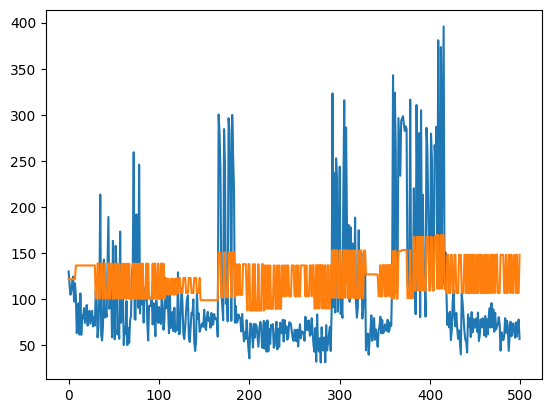

RMSE:


63.75964576451284

In [66]:
#予測結果を入れる空のリストを作成
yHat = []

for i in np.arange(1776, 2276):
  #最後の500レコードをテストデータとする
  learn = dat2[0:i]
  test = dat2[i:i+1]
  #インデックスをリセットする
  learn = learn.reset_index(drop=True)
  test = test.reset_index(drop=True)
  #テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
  learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
  #説明変数と目的変数に分離
  #学習データ
  X_l = learn[['X33', 'X83', 'logX30', 'logX34']]
  Y_l = learn.OV
  #テストデータ
  X_t = test[['X33', 'X83', 'logX30', 'logX34']]
  Y_t = test.OV
  #ランダムフォレストによる木の深さ3の回帰木を構築
  model = SVR(C= 1,degree=2, gamma='scale',kernel='linear')
  model.fit(X_l, Y_l)
  #予測値と観測値の比較
  yHat.append(model.predict(X_t))


Y_t = dat1["OV"][1776:2276]
Y_t = Y_t.reset_index()['OV']
yh = np.array(yHat).T[0]
#予測結果の表示
plt.plot(Y_t)
plt.plot(yh, linestyle='-')
plt.show()

#RMSEの表示
from sklearn.metrics import mean_squared_error
print("RMSE:")
np.sqrt(mean_squared_error(Y_t, yh))

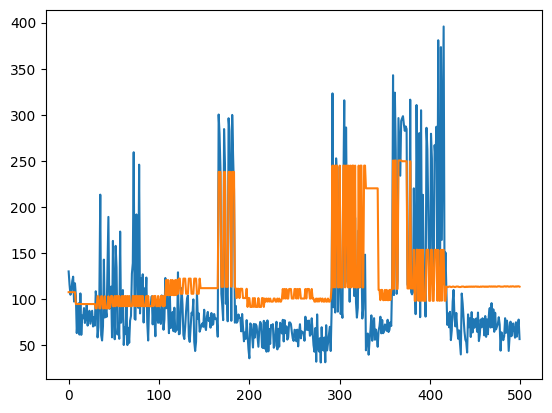

RMSE:


54.69648312675781

In [67]:
yHat = []

for i in np.arange(1776, 2276):
  #最後の500レコードをテストデータとする
  learn = dat1[0:i]
  test = dat1[i:i+1]
  #インデックスをリセットする
  learn = learn.reset_index(drop=True)
  test = test.reset_index(drop=True)
  #テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
  learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
  #説明変数と目的変数に分離
  #学習データ
  X_l = learn[['X25','X30', 'X33', 'X34', 'X37']]
  Y_l = learn.OV
  #テストデータ
  X_t = test[['X25','X30', 'X33', 'X34', 'X37']]
  Y_t = test.OV
  #ランダムフォレストによる木の深さ3の回帰木を構築
  model = SVR(C= 1,degree=2, gamma='scale',kernel='linear')
  model.fit(X_l, Y_l)
  #予測値と観測値の比較
  yHat.append(model.predict(X_t))


Y_t = dat1["OV"][1776:2276]
Y_t = Y_t.reset_index()['OV']
yh = np.array(yHat).T[0]
#予測結果の表示
plt.plot(Y_t)
plt.plot(yh, linestyle='-')
plt.show()

#RMSEの表示
from sklearn.metrics import mean_squared_error
print("RMSE:")
np.sqrt(mean_squared_error(Y_t, yh))

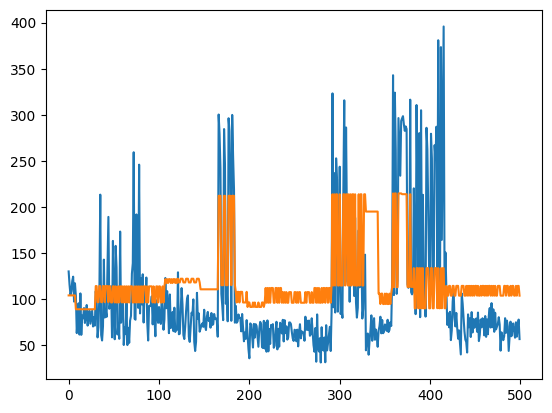

RMSE:


55.07307946750684

In [68]:
yHat = []

for i in np.arange(1776, 2276):
  #最後の500レコードをテストデータとする
  learn = dat1[0:i]
  test = dat1[i:i+1]
  #インデックスをリセットする
  learn = learn.reset_index(drop=True)
  test = test.reset_index(drop=True)
  #テストデータの最初の1レコードの"process_end_time"より前のlearnデータを取り出す
  learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
  #説明変数と目的変数に分離
  #学習データ
  X_l = learn[['X25','X30', 'X33']]
  Y_l = learn.OV
  #テストデータ
  X_t = test[['X25','X30', 'X33']]
  Y_t = test.OV
  #ランダムフォレストによる木の深さ3の回帰木を構築
  model = SVR(C= 1,degree=2, gamma='scale',kernel='linear')
  model.fit(X_l, Y_l)
  #予測値と観測値の比較
  yHat.append(model.predict(X_t))


Y_t = dat1["OV"][1776:2276]
Y_t = Y_t.reset_index()['OV']
yh = np.array(yHat).T[0]
#予測結果の表示
plt.plot(Y_t)
plt.plot(yh, linestyle='-')
plt.show()

#RMSEの表示
from sklearn.metrics import mean_squared_error
print("RMSE:")
np.sqrt(mean_squared_error(Y_t, yh))